In [23]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from numpy import array
from numpy.random import uniform
from numpy import hstack
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [24]:
import pandas as pd
from sklearn.datasets import make_regression
from keras.layers import Dense
import numpy as np
import os
import seaborn as sns
import pandas as pd
from math import e,sqrt
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.optimize import leastsq
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from pyFTS.models.nonstationary import nsfts
from pyFTS.benchmarks import Measures
from pyFTS.benchmarks import Measures
import matplotlib.pyplot as plt
from pyFTS.common import Util
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import datetime
import statistics
import math
import os
import sys
import statistics
sys.path.append("/home/hugo/projetos-doutorado/mimo_emb_fts/src/")

from embfts.util.DataSetUtil import DataSetUtil
from embfts.util.StatisticsUtil import StatisticsUtil

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


In [36]:
data_set_util = DataSetUtil()
statistics_util = StatisticsUtil()

In [37]:
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)

In [38]:
df = pd.read_csv('/home/hugo/projetos-doutorado/mimo_emb_fts/data/energydata_complete.csv', sep=',')
data = df.drop(labels=['date','rv1','rv2'], axis=1)
data = data_set_util.clean_dataset(data)
data = data_set_util.series_to_supervised_mimo(data, 1, 1)
data.head()

,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,T8(t),RH_8(t),T9(t),RH_9(t),T_out(t),Press_mm_hg(t),RH_out(t),Windspeed(t),Visibility(t),Tdewpoint(t)
1,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9
5,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.29,6.016667,734.0,92.0,5.333333,43.833333,4.8


In [ ]:
def create_lstm_model(neurons,activation,in_dim,out_dim):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=in_dim,activation=activation))
    model.add(Dense(out_dim))
    model.compile(loss='mse', optimizer='adam')
    #early_stopping = EarlyStopping(monitor="loss", patience = 5)
      
    return model

In [ ]:
def compile_lstm_model(epochs, model, X_train,y_train, X_test,y_test, batch_size,verbose):
    history_model = model.fit(X_train,y_train,
              validation_data=(X_test,y_test),
              batch_size=batch_size,
              epochs=epochs,
              callbacks = [EarlyStopping(monitor="loss", patience = 5)],
              verbose=verbose)
    model = KerasRegressor(build_fn=model, verbose=0)
    
    return model, history_model

In [ ]:
def plot_history_model(history_model):
    plt.plot(history_model.history['loss'])
    plt.plot(history_model.history['val_loss'])
    plt.title("Model Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Valid'])
    plt.show()

In [ ]:
def sliding_window(data,n_windows,train_size,epochs,batch_size,verbose,neurons,dim_in,dim_out,activation):

    result = {
         "window": [],
         "rmse": [],
         "mape": [],
         "mae": [],
         "r2": [],
         "smape": [],
         "nrmse": [],
         "variable":[]
    }
    
    final_result = {
         "window": [],
         "rmse": [],
         "mape": [],
         "mae": [],
         "r2": [],
         "smape": [],
         "nrmse": [],
         "variable":[]
    }

    tam = len(data)
    windows_length = math.floor(tam / n_windows)
    for ct, ttrain, ttest in Util.sliding_window(data, windows_length, train_size, inc=1):
        if len(ttest) > 0:
            
            print('-' * 20)
            print(f'training window {(ct)}')
            
            scaler = StandardScaler()

            Xtrain = scaler.fit_transform(ttrain.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)'])
            ytrain = scaler.fit_transform(ttrain.loc[:,'Appliances(t)':'Tdewpoint(t)'])
            Xtest = scaler.transform(ttest.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)'])
            ytest = scaler.transform(ttest.loc[:,'Appliances(t)':'Tdewpoint(t)'])
            
#             Xval = Xtest[:int(len(Xtest)*0.25)]
#             yval = ytest[:int(len(ytest)*0.25)]

            Xval = Xtrain[:int(len(Xtrain)*0.15)]
            yval = ytrain[:int(len(ytrain)*0.15)]
            
            X_train = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],1)
            y_train = ytrain.reshape(ytrain.shape[0],ytrain.shape[1],1)
            X_test = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],1)
            y_test = ytest.reshape(ytest.shape[0],ytest.shape[1],1)
            X_val = Xval.reshape(Xval.shape[0],Xval.shape[1],1)
            y_val = yval.reshape(yval.shape[0],yval.shape[1],1)
            
            model = create_lstm_model(neurons,activation,in_dim,out_dim)
            model,history_model = compile_lstm_model(epochs, model, X_train,y_train, X_test,y_test, batch_size, verbose)

             
            plot_history_model(history_model)
            
            df_forecats_columns = ['Appliances(t)', 'lights(t)', 'T1(t)', 'RH_1(t)', 'T2(t)', 'RH_2(t)',
                                   'T3(t)', 'RH_3(t)', 'T4(t)', 'RH_4(t)', 'T5(t)', 'RH_5(t)', 'T6(t)',
                                   'RH_6(t)', 'T7(t)', 'RH_7(t)', 'T8(t)', 'RH_8(t)', 'T9(t)', 'RH_9(t)',
                                   'T_out(t)', 'Press_mm_hg(t)', 'RH_out(t)', 'Windspeed(t)',
                                   'Visibility(t)', 'Tdewpoint(t)']
            columns = list(df_forecats_columns)
            
            prediction = model.predict(X_test)
            prediction = prediction.reshape(prediction.shape[0], prediction.shape[1])
            prediction = scaler.inverse_transform(prediction)            
            df_forecast = pd.DataFrame(prediction,columns=columns)
            
            #ytest_metric = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[2]))
            ytest_metric = ttest.loc[:,'Appliances(t)':'Tdewpoint(t)'].values
            df_original = pd.DataFrame(ytest_metric,columns=columns)
            
            for col in columns:  
                original = df_original[col].values
                forecast = df_forecast[col].values
#                 original = original[:len(original)-1]
#                 forecast = forecast[1:]
                
                mae = round(mean_absolute_error(original,forecast),3)
                r2 = round(r2_score(original,forecast),3)
                #rmse = mean_squared_error(original,forecast,squared=False)
                rmse = round(Measures.rmse(original,forecast),3)
                mape = round(Measures.mape(original,forecast),3)
                nrmse = round(cal_nrmse(rmse, original),3)
                smape = round(Measures.smape(original,forecast),3)

                result["rmse"].append(rmse)
                result["nrmse"].append(nrmse)
                result["mape"].append(mape)
                result["mae"].append(mae)
                result["r2"].append(r2)
                result["smape"].append(smape)
                result["window"].append(ct)
                result["variable"].append(col)
                
#                 fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
#                 ax.plot(original, label='Original')
#                 ax.plot(forecast, label='Forecast')
#                 handles, labels = ax.get_legend_handles_labels()
#                 lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
#                 plt.show()
        
    measures = pd.DataFrame(result)
    return measures

--------------------
training window 0


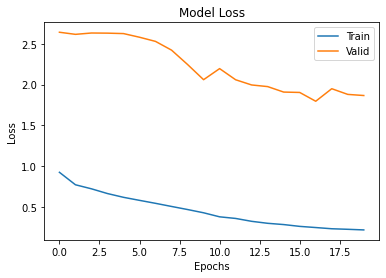

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 657


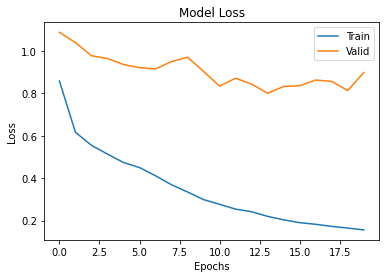

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 1314


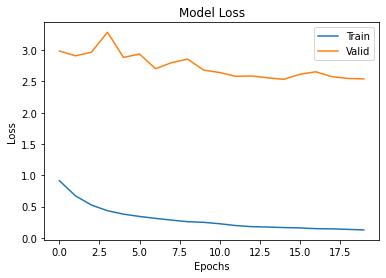

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
<ipython-input-37-1be783193a86>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (rmse/x)


--------------------
training window 1971


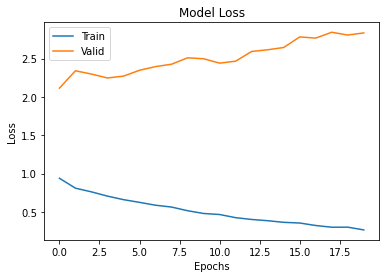

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 2628


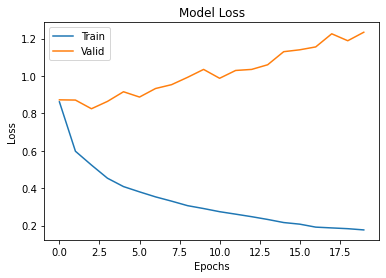

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 3285


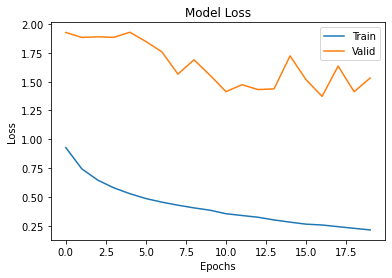

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 3942


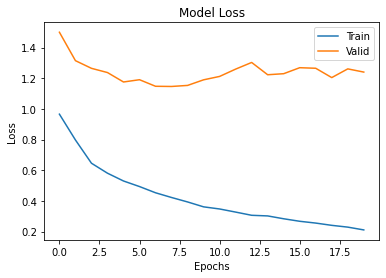

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 4599


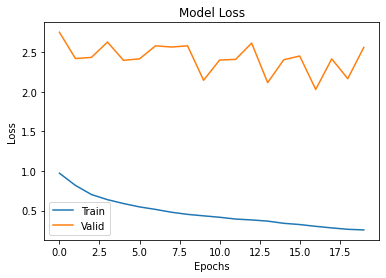

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 5256


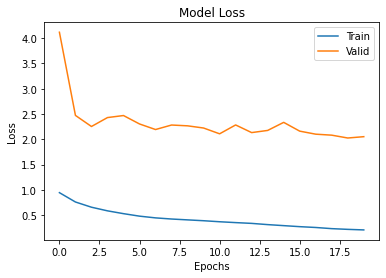

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 5913


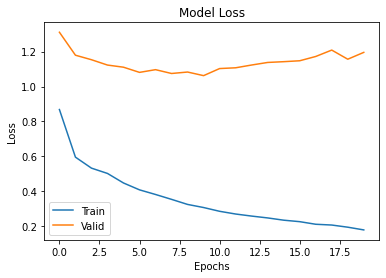

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 6570


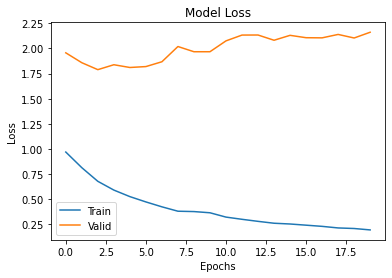

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 7227


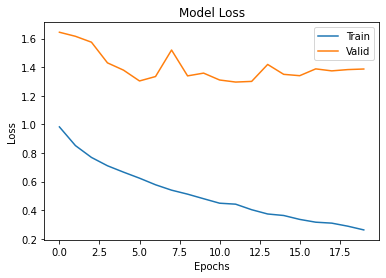

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 7884


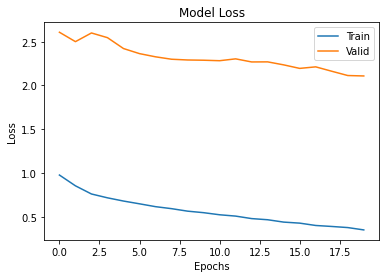

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 8541


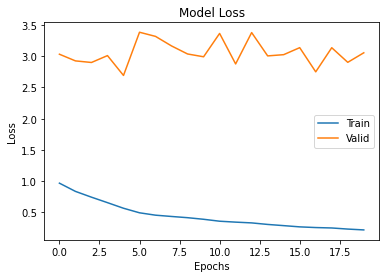

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 9198


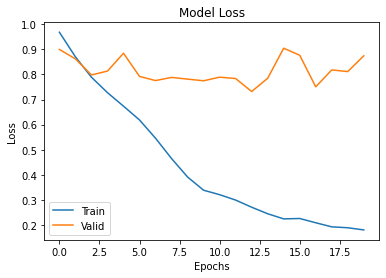

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 9855


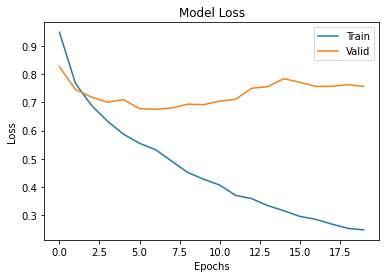

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 10512


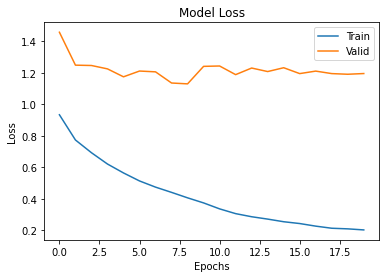

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 11169


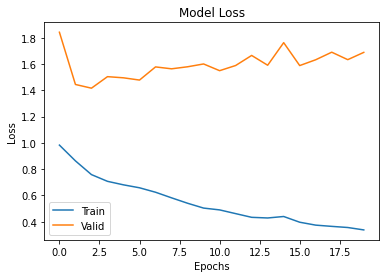

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
<ipython-input-37-1be783193a86>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (rmse/x)


--------------------
training window 11826


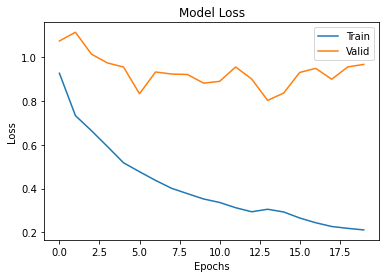

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 12483


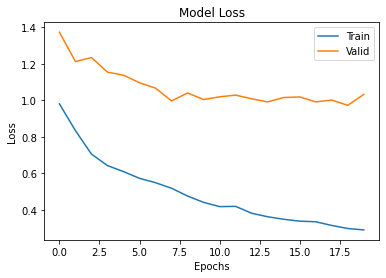

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 13140


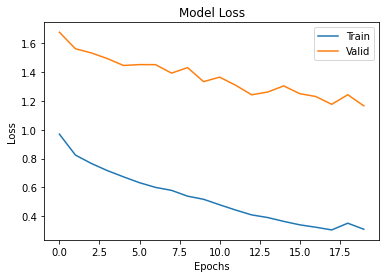

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 13797


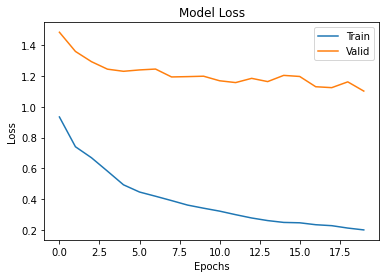

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 14454


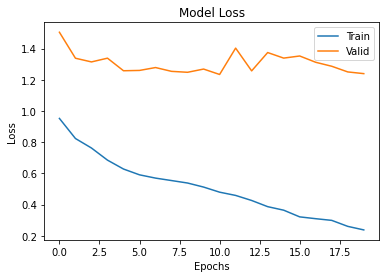

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 15111


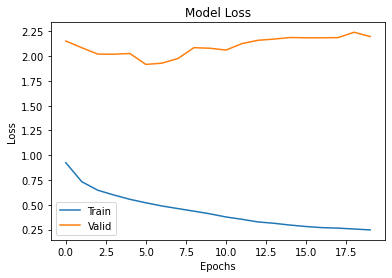

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 15768


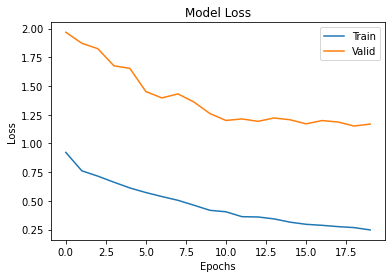

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 16425


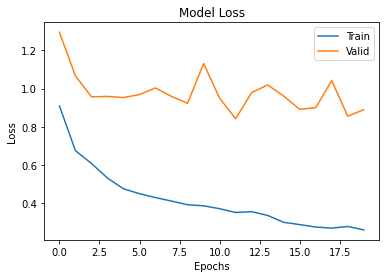

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 17082


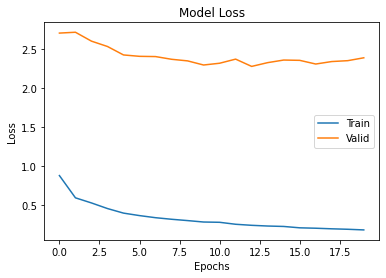

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 17739


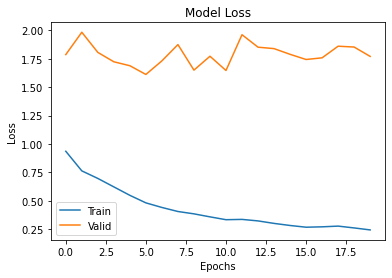

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 18396


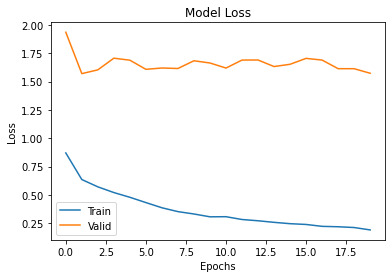

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


--------------------
training window 19053


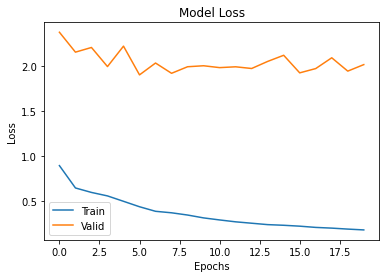

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/benchmarks/Measures.py:83: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


In [69]:
# Best Parameters = {'activation': 'tanh', 'batch_size': 16, 'neurons1': 98}

n_windows = 30
train_size = 0.75 
epochs = 20
batch_size = 32
verbose = 0
neurons = 98 
activation = 'tanh'
in_dim = (data.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)'].shape[1], 1)
out_dim = data.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)'].shape[1]


model_result = sliding_window(data,n_windows,train_size,epochs,batch_size,verbose,neurons,in_dim,out_dim,activation)

In [72]:
df_forecats_columns = ['Appliances(t)', 'lights(t)', 'T1(t)', 'RH_1(t)', 'T2(t)', 'RH_2(t)',
                                   'T3(t)', 'RH_3(t)', 'T4(t)', 'RH_4(t)', 'T5(t)', 'RH_5(t)', 'T6(t)',
                                   'RH_6(t)', 'T7(t)', 'RH_7(t)', 'T8(t)', 'RH_8(t)', 'T9(t)', 'RH_9(t)',
                                   'T_out(t)', 'Press_mm_hg(t)', 'RH_out(t)', 'Windspeed(t)',
                                   'Visibility(t)', 'Tdewpoint(t)']

columns = list(df_forecats_columns)

final_result = {
    "variable": [],
    "rmse": [],
    "mae": [],
    "mape": [],
    "r2": [],
    "smape": [],
    "nrmse": []
}

measures = model_result
var = measures.groupby("variable")

for col in columns:
    
    var_agr = var.get_group(col)
           
    rmse = round(statistics.mean(var_agr.loc[:,'rmse']),3)
    mape = round(statistics.mean(var_agr.loc[:,'mape']),3)
    mae = round(statistics.mean(var_agr.loc[:,'mae']),3)
    r2 = round(statistics.mean(var_agr.loc[:,'r2']),3)
    smape = round(statistics.mean(var_agr.loc[:,'smape']),3)
    nrmse = round(statistics.mean(var_agr.loc[:,'nrmse']),3)

    final_result["variable"].append(col)
    final_result["rmse"].append(rmse)
    final_result["mape"].append(mape)
    final_result["mae"].append(mae)
    final_result["r2"].append(r2)
    final_result["smape"].append(mae)
    final_result["nrmse"].append(r2)
        
    #print(f'Results: {(col,rmse,mae,r2)}')
        
        
final_measures = round(pd.DataFrame(final_result),3)

In [73]:
final_measures

,variable,rmse,mae,mape,r2,smape,nrmse
0,Appliances(t),99.762,66.867,83.026,-3.699000e+00,66.867,-3.699000e+00
1,lights(t),7.569,5.161,inf,-6.270000e-01,5.161,-6.270000e-01
2,T1(t),0.755,0.629,2.947,-8.420000e-01,0.629,-8.420000e-01
3,RH_1(t),1.986,1.594,3.975,-1.026000e+00,1.594,-1.026000e+00
4,T2(t),1.180,0.952,4.557,-4.840000e-01,0.952,-4.840000e-01
5,RH_2(t),2.557,2.142,5.416,-1.036000e+00,2.142,-1.036000e+00
6,T3(t),0.772,0.642,2.866,-2.857000e+00,0.642,-2.857000e+00
7,RH_3(t),1.402,1.142,2.914,-1.112000e+00,1.142,-1.112000e+00
8,T4(t),0.995,0.867,4.293,-3.687000e+00,0.867,-3.687000e+00
9,RH_4(t),1.578,1.315,3.370,-1.671000e+00,1.315,-1.671000e+00


## MinMaxScaler+RandomizedSearchCV

In [7]:
x,y=data.loc[:,:],data.loc[:,:]


In [8]:
from sklearn.preprocessing import MinMaxScaler
scalerx = MinMaxScaler()
scalery=MinMaxScaler()




In [10]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)
df_trainx=x_train.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)']
df_trainx_scaled = scalerx.fit_transform(df_trainx)
df_testx=x_test.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)']
df_testx_scaled = scalerx.transform(df_testx)
df_trainy=y_train.loc[:,'Appliances(t)':'Tdewpoint(t)']
df_trainy_scaled=scalery.fit_transform(df_trainy)

df_original=y_test.loc[:,'Appliances(t)':'Tdewpoint(t)']


In [11]:
trainx_scaled = df_trainx_scaled.reshape(df_trainx_scaled .shape[0],df_trainx_scaled .shape[1],1)
testx_scaled = df_testx_scaled.reshape(df_testx_scaled .shape[0], df_testx_scaled .shape[1], 1)


In [12]:
print(trainx_scaled.shape,testx_scaled.shape,df_trainy_scaled.shape)

(14800, 26, 1) (4934, 26, 1) (14800, 26)


In [13]:
in_dim = (trainx_scaled.shape[1], trainx_scaled.shape[2])
out_dim = df_trainy.shape[1]
print(in_dim)
print(out_dim)

(26, 1)
26


In [14]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
def get_model(neurons1=32,batch_size=32,activation='relu'):
  model = Sequential()
  model.add(LSTM(neurons1, input_shape=in_dim,activation=activation))
  model.add(Dense(out_dim))
  model.compile(loss='mse', optimizer='adam')
  early_stopping = EarlyStopping(monitor="loss", patience = 5)# early stop patience
  history = model.fit(trainx_scaled,df_trainy_scaled,
              batch_size=batch_size,
              epochs=20,
              callbacks = [early_stopping],
              verbose=0) #verbose set to 1 will show the training process
    
  return model

  

In [15]:
clf = KerasRegressor(build_fn=get_model, verbose=0)

In [16]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
rf_params = {
    'activation': ['relu','tanh'],
    'batch_size': [16,32,64],
    'neurons1':sp_randint(10,100)
    #'epochs':[20,50,100,200],
   
}

Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=10,cv=3,scoring='neg_mean_squared_error')

hyperparameters_tuning = Random.fit(trainx_scaled,df_trainy_scaled)
print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

tuned_model = hyperparameters_tuning.best_estimator_

Best Parameters = {'activation': 'tanh', 'batch_size': 16, 'neurons1': 98}


In [17]:
hyperparameters_tuning.best_estimator_

In [22]:
y_p=tuned_model.predict(testx_scaled)
columns=df_original.columns
y_p=pd.DataFrame(y_p,columns=columns)
y_p

,Appliances(t),lights(t),T1(t),RH_1(t),T2(t),RH_2(t),T3(t),RH_3(t),T4(t),RH_4(t),...,T8(t),RH_8(t),T9(t),RH_9(t),T_out(t),Press_mm_hg(t),RH_out(t),Windspeed(t),Visibility(t),Tdewpoint(t)
0,0.024419,0.026406,0.819143,0.664040,0.476822,0.792478,0.760869,0.715213,0.890094,0.731024,...,0.914735,0.792168,0.925088,0.735152,0.626309,0.440502,0.915287,0.212527,0.586734,0.909403
1,0.016929,0.017287,0.452408,0.305518,0.175396,0.517164,0.277148,0.337618,0.449458,0.305098,...,0.543853,0.333236,0.411622,0.415170,0.314819,0.859955,0.798000,0.142176,0.741264,0.404088
2,0.042362,0.026605,0.438023,0.283544,0.321451,0.393988,0.363148,0.300865,0.523069,0.290939,...,0.492448,0.221010,0.464960,0.199224,0.414155,0.550435,0.564353,0.431844,0.589052,0.397747
3,0.104132,0.310368,0.510389,0.405371,0.275497,0.557014,0.317433,0.435208,0.444421,0.522044,...,0.407546,0.460106,0.308636,0.413352,0.380383,0.513792,0.942981,0.572287,0.752400,0.586445
4,0.037021,0.022224,0.418583,0.544074,0.215401,0.668421,0.367540,0.645998,0.505795,0.611432,...,0.490057,0.727335,0.356200,0.684802,0.285348,0.558018,0.936231,0.096163,0.374777,0.438372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4929,0.055778,0.032378,0.442646,0.448949,0.254291,0.553206,0.302456,0.570577,0.382316,0.541535,...,0.516089,0.575588,0.391535,0.619033,0.256438,0.341990,0.872179,0.296848,0.385302,0.367993
4930,0.049993,0.017661,0.382044,0.467723,0.208031,0.584189,0.331804,0.593086,0.326925,0.546715,...,0.459700,0.629422,0.364137,0.645394,0.256629,0.127968,0.917411,0.182307,0.796968,0.385550
4931,0.028010,0.005224,0.449700,0.266729,0.144582,0.495730,0.391809,0.328977,0.448935,0.241707,...,0.543741,0.401664,0.470764,0.417712,0.241935,0.482670,0.805519,0.354801,0.606631,0.315635
4932,0.030480,0.016260,0.531962,0.638628,0.407514,0.655867,0.396571,0.754379,0.446102,0.859675,...,0.361291,0.715854,0.353390,0.837679,0.477081,0.760673,0.857759,0.431240,0.559656,0.673707


In [23]:
y_p_inv = scalery.inverse_transform(y_p)
columns=df_original.columns
y_p_inv=pd.DataFrame(y_p_inv,columns=columns)
y_p_inv

,Appliances(t),lights(t),T1(t),RH_1(t),T2(t),RH_2(t),T3(t),RH_3(t),T4(t),RH_4(t),...,T8(t),RH_8(t),T9(t),RH_9(t),T_out(t),Press_mm_hg(t),RH_out(t),Windspeed(t),Visibility(t),Tdewpoint(t)
0,36.128525,1.848434,24.547283,47.369507,22.659487,48.646488,26.357817,44.069836,24.980047,44.768391,...,26.303360,52.715469,23.780094,46.927944,14.478223,748.241577,93.561821,2.975383,39.137688,13.497804
1,28.114134,1.210100,21.074303,36.384392,18.512859,38.855427,20.535755,35.990566,20.088984,34.800320,...,22.272699,39.323818,18.845682,39.197186,4.790856,766.278137,84.648033,1.990469,49.182186,2.330344
2,55.327354,1.862352,20.938080,35.711136,20.522093,34.474857,21.570847,35.204170,20.906063,34.468945,...,21.714043,36.049080,19.358263,33.979916,7.880236,752.968750,66.890823,6.045815,39.288372,2.190207
3,121.421394,21.725761,21.623384,39.443909,19.889923,40.272598,21.020624,38.078663,20.033073,39.877583,...,20.791338,43.025894,17.855997,39.153244,6.829906,751.393005,95.666595,8.012016,49.906021,6.360427
4,49.612068,1.555709,20.753983,43.693752,19.063204,44.234619,21.623709,42.588882,20.714321,41.969559,...,21.688055,50.823620,18.313078,45.711483,3.874332,753.294800,95.153580,1.346287,25.360498,3.088012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4929,69.682724,2.266443,20.981861,40.779118,19.598194,40.137173,20.840363,40.975109,19.343704,40.333725,...,21.970961,46.395649,18.652651,44.122498,2.975223,744.005615,90.285614,4.155868,26.044607,1.532640
4930,63.493042,1.236287,20.407955,41.354355,18.961817,41.239025,21.193598,41.456726,18.728872,40.454948,...,21.358141,47.966541,18.389355,44.759392,2.981170,734.802612,93.723267,2.552299,52.802891,1.920650
4931,39.971184,0.365681,21.048656,35.195919,18.088972,38.093128,21.915812,35.805676,20.083178,33.316746,...,22.271482,41.320553,19.414038,39.258579,2.524179,750.054871,85.219467,4.967220,40.430992,0.375523
4932,42.614117,1.138190,21.827682,46.590885,21.706041,43.788136,21.973125,44.907864,20.051735,47.779274,...,20.288658,50.488621,18.286079,49.404991,9.837205,762.008911,89.189674,6.037362,37.377640,8.288916


In [24]:
df_original

,Appliances(t),lights(t),T1(t),RH_1(t),T2(t),RH_2(t),T3(t),RH_3(t),T4(t),RH_4(t),...,T8(t),RH_8(t),T9(t),RH_9(t),T_out(t),Press_mm_hg(t),RH_out(t),Windspeed(t),Visibility(t),Tdewpoint(t)
17335,50.0,0.0,24.79,47.290000,22.89,49.290000,26.660000,43.500000,25.000000,45.400000,...,26.100000,52.790000,24.040000,47.134000,14.600000,748.900000,94.000000,2.833333,40.0,13.600000
8680,40.0,10.0,21.20,36.290000,18.60,39.466667,20.200000,36.500000,19.790000,34.700000,...,22.200000,39.626667,18.500000,39.500000,5.033333,766.600000,84.333333,2.000000,48.0,2.566667
15392,70.0,0.0,20.89,35.826667,20.29,34.700000,21.390000,35.090000,20.730000,34.826667,...,21.566667,36.163333,19.290000,33.826667,7.800000,752.833333,67.666667,6.000000,40.0,2.200000
7221,110.0,20.0,21.50,38.966667,19.70,39.900000,20.823333,38.126667,19.926667,40.333333,...,20.790000,42.626667,17.790000,38.500000,6.900000,751.850000,96.000000,8.000000,53.0,6.300000
6111,60.0,0.0,21.00,43.400000,19.29,44.500000,21.700000,42.590000,21.000000,41.290000,...,21.390000,50.400000,18.557143,45.914286,3.750000,753.800000,95.500000,1.500000,26.5,3.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4560,40.0,0.0,20.50,41.333333,19.70,40.000000,20.760000,41.200000,19.200000,39.730000,...,21.700000,46.120000,18.700000,44.090000,2.700000,744.500000,91.000000,4.000000,27.0,1.400000
4827,60.0,0.0,20.60,40.090000,18.79,41.530000,21.390000,40.826667,18.790000,41.200000,...,21.290000,47.602222,18.200000,45.400000,2.500000,734.550000,95.500000,2.500000,52.5,1.850000
15322,50.0,0.0,21.00,35.400000,18.00,38.260000,22.000000,35.900000,19.790000,33.290000,...,22.290000,41.200000,19.390000,39.363333,2.633333,749.766667,84.666667,5.000000,40.0,0.333333
3582,50.0,0.0,22.00,46.166667,21.60,44.000000,21.908333,44.700000,20.066667,48.700000,...,20.100000,50.580000,18.600000,48.826667,9.800000,762.100000,90.000000,6.000000,40.0,8.200000


In [25]:
col=df_original.columns
result = {
        
         "rmse": [],
         
         "mae": [],
         "r2": [],
         "mape":[],
         "variable":[]
    }
    
final_result = {
        
         "rmse": [],
         
         "mae": [],
         "r2": [],
         "mape":[],
         "variable":[]}
for col in col: 
  original = df_original[col].values
  forecast = y_p_inv[col].values
  mae = round(mean_absolute_error(original,forecast),3)
  r2 = round(r2_score(original,forecast),3)
  rmse = round(mean_squared_error(original,forecast,squared=False),3)             
  mape = round(mean_absolute_percentage_error(original,forecast),3)

  result["rmse"].append(rmse)
  result["mae"].append(mae)
  result["r2"].append(r2)
  result["mape"].append(mape)
  
  result["variable"].append(col)
        
measures = pd.DataFrame(result)

In [26]:
import statistics
final_result = {
    "variable": [],
    "rmse": [],
    # "nrmse": [],
    "mae": [],
    "r2": [],
    "mape":[]
}


var = measures.groupby("variable")

for col in columns:
    
    var_agr = var.get_group(col)
           
    rmse = round(statistics.mean(var_agr.loc[:,'rmse']),3)
    # nrmse = round(statistics.mean(var_agr.loc[:,'nrmse']),3)
    mae = round(statistics.mean(var_agr.loc[:,'mae']),3)
    r2 = round(statistics.mean(var_agr.loc[:,'r2']),3)
    mape = round(statistics.mean(var_agr.loc[:,'mape']),3)

    final_result["variable"].append(col)
    final_result["rmse"].append(rmse)
    # final_result["nrmse"].append(nrmse)
    final_result["mae"].append(mae)
    final_result["r2"].append(r2)
    final_result["mape"].append(mape)
        
    print(f'Results: {(col,rmse,mae,r2,mape)}')
        
        
final_measures_kpca = pd.DataFrame(final_result) 

print("Statistics MIMO (test): ")
final_measures_kpca

Results: ('Appliances(t)', 71.4, 34.499, 0.499, 0.323)
Results: ('lights(t)', 4.929, 3.103, 0.606, 6253235779767717.0)
Results: ('T1(t)', 0.232, 0.18, 0.979, 0.008)
Results: ('RH_1(t)', 0.828, 0.573, 0.956, 0.014)
Results: ('T2(t)', 0.285, 0.208, 0.983, 0.01)
Results: ('RH_2(t)', 0.821, 0.633, 0.959, 0.016)
Results: ('T3(t)', 0.244, 0.19, 0.985, 0.009)
Results: ('RH_3(t)', 0.547, 0.415, 0.971, 0.011)
Results: ('T4(t)', 0.254, 0.198, 0.984, 0.01)
Results: ('RH_4(t)', 0.595, 0.457, 0.981, 0.012)
Results: ('T5(t)', 0.21, 0.144, 0.987, 0.007)
Results: ('RH_5(t)', 2.8, 1.678, 0.904, 0.033)
Results: ('T6(t)', 0.931, 0.704, 0.977, 4643298255223.521)
Results: ('RH_6(t)', 2.407, 1.853, 0.994, 0.179)
Results: ('T7(t)', 0.23, 0.181, 0.988, 0.009)
Results: ('RH_7(t)', 0.56, 0.441, 0.988, 0.013)
Results: ('T8(t)', 0.188, 0.151, 0.991, 0.007)
Results: ('RH_8(t)', 0.478, 0.369, 0.992, 0.009)
Results: ('T9(t)', 0.178, 0.137, 0.992, 0.007)
Results: ('RH_9(t)', 0.377, 0.288, 0.992, 0.007)
Results: ('T_o

,variable,rmse,mae,r2,mape
0,Appliances(t),71.400,34.499,0.499,3.230000e-01
1,lights(t),4.929,3.103,0.606,6.253236e+15
2,T1(t),0.232,0.180,0.979,8.000000e-03
3,RH_1(t),0.828,0.573,0.956,1.400000e-02
4,T2(t),0.285,0.208,0.983,1.000000e-02
5,RH_2(t),0.821,0.633,0.959,1.600000e-02
6,T3(t),0.244,0.190,0.985,9.000000e-03
7,RH_3(t),0.547,0.415,0.971,1.100000e-02
8,T4(t),0.254,0.198,0.984,1.000000e-02
9,RH_4(t),0.595,0.457,0.981,1.200000e-02
